# Lab 4

## Introduction

### PCA/Clustering
This marks the first <a href="http://en.wikipedia.org/wiki/Unsupervised_learning">unsupervised learning</a> lab. There are several aspects to unsupervised learning:

* Data has no labels
* The goal is to find structure
* The most "popular" aspect is clustering
* It also includes dimensionality reduction and feature extraction

This lab will focus on dimensionality reduction via <a href="http://en.wikipedia.org/wiki/Principal_component_analysis">PCA</a> (<a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">Principal Component Analysis</a>). As well as an introduction to <a href="http://en.wikipedia.org/wiki/K-means_clustering">K-means</a> clustering.

### Lab
In this lab you, as analyst, have a list of domains and the related blacklists they appear on. In addition some of these domains were responsible for sending a file to the client. These files have been run through <a href="https://www.virustotal.com/">VirusTotal</a> and the AV results are also available with the domains. The goal is to explore the data, find some structure and attempt to find a way to gain confidence in what domains are more malicious as a means of prioritization. As with any type of data exploration, it's not a silver bullet but perhaps you'll gain an understanding of the data
___
## Exercises
### File Input - Blacklist Data
The data for the lab is contained in *host_detections.csv* and has columns: *host*, *detections*, and *detection_count*.

In [1]:
import pandas as pd

df = pd.read_csv('host_detections.csv', header=1, names=['host','detections','detection_count'], encoding='utf-8')

<font color='blue'>
I had to check the solution manual to see how the data was read into a dataframe since it has a header. I was getting a TypeError because I imported the data incorrectly.
</font>

### Cleanup - Blacklist Data
Drop the duplicates on the *df* dataframe, for column *host*

In [2]:
df.drop_duplicates(subset='host', inplace=True)

<font color='blue'>
Since inplace=True, rows will be dropped when there are duplicates of host values.
    
https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/
</font>

In [3]:
df.head()

,host,detections,detection_count
0,02b123c.netsolhost.com,0,0
1,0hb.ru,"[u'MyWOT', u'SURBL', u'BitDefender']",3
2,0lilioo0l0o00lilil.info,"[u'MyWOT', u'SCUMWARE', u'SURBL', u'hpHosts', ...",7
3,0n1u4og97yt85sy8faitxwt.addirectory.org,0,0
4,0td4nbde7.ttl60.com,"[u'SpamhausDBL', u'BitDefender']",2


<font color='blue'>
I have added df.head() to take a peek at the data.
</font>

This next section cleans up the detections column. It removes the text formatting and puts the information into a Python list, and places the Python list back into the dataframe in place of the text. It also creates a multi-dimensional list that represents the the various blacklists and if there was a hit for the domain *1* or not *0*. 

In [4]:
black_list_sources = set()
def get_list(x):
    detections = []
    if not (len(x) == 1 and int(x) == 0):
        x = x.replace(" ", "")
        x = x.replace("u'", "")
        x = x.replace("'", "")
        x = x.replace("[", "")
        x = x.replace("]", "")
        [black_list_sources.add(i) for i in x.split(',') if len(i) > 1]
        [detections.append(i) for i in x.split(',') if len(i) > 1]
    return detections
df.detections = df.detections.apply(lambda x: get_list(x))

In [5]:
df.head()

,host,detections,detection_count
0,02b123c.netsolhost.com,[],0
1,0hb.ru,"[MyWOT, SURBL, BitDefender]",3
2,0lilioo0l0o00lilil.info,"[MyWOT, SCUMWARE, SURBL, hpHosts, DrWeb, Googl...",7
3,0n1u4og97yt85sy8faitxwt.addirectory.org,[],0
4,0td4nbde7.ttl60.com,"[SpamhausDBL, BitDefender]",2


<font color='blue'>
The detections column is cleaned up. 
</font>

Join the resulting multi-dimensional list to the "side" of the existing dataframe. 

You can see the host **02b123c.netsolhost.com** has 0 detections, and has *0*s in place for all of the blacklist values. Where **0lilioo0l0o00lilil.info** has 7 detections and a *1* in place of it's detections (e.g. hpHosts).

In [6]:
df = df.join(pd.DataFrame(index=df.index, columns=black_list_sources), rsuffix='_right')
df = df.fillna(0)
for i in df.index:
    for x in df.xs(i)['detections']:
        df.loc[i, x] = 1
df.head()

,host,detections,detection_count,PhishTank,DrWeb,MalwarePatrol,DShield,urlQuery,Fortinet,SCUMWARE,...,GoogleSafeBrowsing,None,Avira,YandexSafeBrowsing,z_protect,CRDF,URLVir,hpHosts,SURBL,ZeuSTracker
0,02b123c.netsolhost.com,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0hb.ru,"[MyWOT, SURBL, BitDefender]",3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0lilioo0l0o00lilil.info,"[MyWOT, SCUMWARE, SURBL, hpHosts, DrWeb, Googl...",7,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0
3,0n1u4og97yt85sy8faitxwt.addirectory.org,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0td4nbde7.ttl60.com,"[SpamhausDBL, BitDefender]",2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color='blue'>
This loop is placing ones for each of blacklist service (column) listed in the array from the detections column. 
    

1. Changed .ix to .loc due to deprecation warning for .ix:

DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

2. Added a suffix in df.join because of ValueError message: 
ValueError: columns overlap but no suffix specified:

https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
</font>

In [7]:
list(df.columns.values)

['host',
 'detections',
 'detection_count',
 'PhishTank',
 'DrWeb',
 'MalwarePatrol',
 'DShield',
 'urlQuery',
 'Fortinet',
 'SCUMWARE',
 'BitDefender',
 'Malc0de',
 'BrowserDefender',
 'DNS-BH',
 'ThreatLog',
 'Quttera',
 'AVGThreatLabs',
 'MyWOT',
 'MalwareDomainList',
 'Sucuri',
 'SpamhausDBL',
 'GoogleSafeBrowsing',
 'None',
 'Avira',
 'YandexSafeBrowsing',
 'z_protect',
 'CRDF',
 'URLVir',
 'hpHosts',
 'SURBL',
 'ZeuSTracker']

<font color='blue'>
Above lists all of the columns for the dataframe df after the join.    
    
http://www.datasciencemadesimple.com/get-list-column-headers-column-name-python-pandas/
</font>

### File Input - VirusTotal
The data is in a file named *mal_domains.csv* and has columns: *host*, *count*, and *detections*. This data has been pre-processed to save some pain on parsing and assembling massive amounts of JSON data.

In [8]:
av_domains = pd.read_csv('mal_domains.csv', header=1, names=['host','count','detections'], encoding='utf-8')
av_domains.head()

,host,count,detections
0,aiwrm.dnepr.com,37,"MicroWorld-eScan,nProtect,CAT-QuickHeal,McAfee..."
1,bgueeew.tk,34,"nProtect,CAT-QuickHeal,McAfee,TheHacker,NOD32,..."
2,hysteonlinexp.com,48,"Bkav,MicroWorld-eScan,nProtect,CAT-QuickHeal,M..."
3,csancho.info,28,"nProtect,McAfee,TheHacker,K7AntiVirus,VirusBus..."
4,fictinwise.cu.cc,48,"Bkav,MicroWorld-eScan,nProtect,K7AntiVirus,Agn..."


<font color='blue'>
Import the data to av_domains as it is used the next cell block for cleanup.

Use .head() to take a peek at the data before cleanup.
</font>

### Cleanup - VirusTotal
Similar to the above we clean-up the detections column.

In [9]:
av_list_sources = set()
def get_list(x):
    detections = []
    if not (len(x) == 1 and int(x) == 0):
        x = x.replace(" ", "")
        x = x.replace("u'", "")
        x = x.replace("'", "")
        x = x.replace("[", "")
        x = x.replace("]", "")
        [av_list_sources.add(i) for i in x.split(',') if len(i) > 1]
        [detections.append(i) for i in x.split(',') if len(i) > 1]
    return detections
av_domains.detections = av_domains.detections.apply(lambda x: get_list(x))
av_domains.head()

,host,count,detections
0,aiwrm.dnepr.com,37,"[MicroWorld-eScan, nProtect, CAT-QuickHeal, Mc..."
1,bgueeew.tk,34,"[nProtect, CAT-QuickHeal, McAfee, TheHacker, N..."
2,hysteonlinexp.com,48,"[Bkav, MicroWorld-eScan, nProtect, CAT-QuickHe..."
3,csancho.info,28,"[nProtect, McAfee, TheHacker, K7AntiVirus, Vir..."
4,fictinwise.cu.cc,48,"[Bkav, MicroWorld-eScan, nProtect, K7AntiVirus..."


A little massaging is necessary here because there are blacklists and AV engines that have the same name. This renames the columns and places an *av_* prefix to the name ensuring there are no duplicates, and has the extra advantage of allow easy distinction in analysis.

Also, join the AV dataframe to the blacklist one created above.

In [10]:
new_cols = list(av_domains.columns)
new_cols = ['av_' + x for x in new_cols]
df = df.join(pd.DataFrame(index=df.index, columns=new_cols))

<font color='blue'>
    
There was an error in creating new_cols:
    
TypeError: unsupported operand type(s) for -: 'str' and 'str'

Looks like host was being removed from the columns list: new_cols = av_domains.columns - ['host']

I changed new_cols to be a list of columns of av_columns and ran the code as is. I dropped the column, av_host, in the next cell instead of playing around with immutable lists:

https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe
</font>

In [11]:
del df['av_host']

<font color='blue'>
Delete the column av_host from the dataframe df as it is not needed.
</font>

This is where the expansion, and then filling in of values, *1* for detection and *0* for no detection, happens.

In [12]:
for i in df.index:
    host = df.xs(i)['host']
    avs = av_domains[av_domains['host'] == host]['detections']
    if len(avs) > 0:
        for a in avs.values.tolist()[0]:
            df.loc[i, 'av_' + a] = 1
        df.loc[i, 'av_count'] = av_domains[av_domains['host'] == host]['count'].values[0]
        df.loc[i, 'av_detections'] = av_domains[av_domains['host'] == host]['detections'].values

In [13]:
df[['host', 'av_count','av_detections']].head()

,host,av_count,av_detections
0,02b123c.netsolhost.com,NaN,NaN
1,0hb.ru,36,"[Bkav, MicroWorld-eScan, McAfee, TheHacker, K7..."
2,0lilioo0l0o00lilil.info,16,"[F-Secure, AntiVir, ESET-NOD32, McAfee-GW-Edit..."
3,0n1u4og97yt85sy8faitxwt.addirectory.org,32,"[F-Secure, DrWeb, VIPRE, AntiVir, TrendMicro, ..."
4,0td4nbde7.ttl60.com,46,"[Bkav, MicroWorld-eScan, nProtect, CMC, CAT-Qu..."


<font color='blue'>

Changed .ix to .loc due to deprecation warning for .ix.

The values filled for av_count and av_detections came from the original count and detections columns that were in av_domains. Like before, the loop is placing ones for each antivirus software (column) listed in the array from the detections column. 

https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
</font>

In [14]:
df.av_detections = df.av_detections.apply(lambda x: [] if isinstance(x, float) or len(x) < 1 else x[0])

In [15]:
df[['host', 'av_count','av_detections']].head()

,host,av_count,av_detections
0,02b123c.netsolhost.com,NaN,[]
1,0hb.ru,36,Bkav
2,0lilioo0l0o00lilil.info,16,F-Secure
3,0n1u4og97yt85sy8faitxwt.addirectory.org,32,F-Secure
4,0td4nbde7.ttl60.com,46,Bkav


<font color='blue'>
The av_detections column is modified so that each row reflects the first antivirus software listed in the detections array for a particular host. 
</font>

In [16]:
df = df.fillna(0)
#del df['None']

In [17]:
df.head()

,host,detections,detection_count,PhishTank,DrWeb,MalwarePatrol,DShield,urlQuery,Fortinet,SCUMWARE,...,av_VirusBuster,av_ClamAV,av_Avast5,av_Zillya,av_AegisLab,av_Zoner,av_AVware,av_eScan,av_Prevx,av_McAfee+Artemis
0,02b123c.netsolhost.com,[],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0hb.ru,"[MyWOT, SURBL, BitDefender]",3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0lilioo0l0o00lilil.info,"[MyWOT, SCUMWARE, SURBL, hpHosts, DrWeb, Googl...",7,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0n1u4og97yt85sy8faitxwt.addirectory.org,[],0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0td4nbde7.ttl60.com,"[SpamhausDBL, BitDefender]",2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For consistency's sake, set all of the columns but *host*, *detections*, and *av_detections* to type **int**

In [18]:
int_cols = [x for x in list(df.columns) if not x in ['host','detections','av_detections']]
df[int_cols] = df[int_cols].astype(int)

<font color='blue'>
There was an error in creating int_cols: list(df.columns - ['host','detections','av_detections'])
    
ValueError: operands could not be broadcast together with shapes (97,) (3,)

So, I created int_cols using a list comprehension. I did a sanity check in the next cell block.

https://realpython.com/list-comprehension-python/
https://www.jquery-az.com/4-demos-python-if-not-and-not-in-operator/
</font>

In [19]:
df.dtypes

host                      object
detections                object
detection_count            int32
PhishTank                  int32
DrWeb                      int32
MalwarePatrol              int32
DShield                    int32
urlQuery                   int32
Fortinet                   int32
SCUMWARE                   int32
BitDefender                int32
Malc0de                    int32
BrowserDefender            int32
DNS-BH                     int32
ThreatLog                  int32
Quttera                    int32
AVGThreatLabs              int32
MyWOT                      int32
MalwareDomainList          int32
Sucuri                     int32
SpamhausDBL                int32
GoogleSafeBrowsing         int32
None                       int32
Avira                      int32
YandexSafeBrowsing         int32
z_protect                  int32
CRDF                       int32
URLVir                     int32
hpHosts                    int32
SURBL                      int32
          

<font color='blue'>
Use .dtypes to check that types of the columns. 
</font>

Take a look at the resulting dataframe, you'll see a similar structure to the one above.

The cell below shows how to print the dimensions of the dataframe, in this case it has 346 rows and 97 columns (e.g. dimensions). This is due to the selection clause, it looks for domains that have zero AV results against it, and more than one blacklist hit.

Try reversing the query *av_count* > 0 and *detection_count* == 0.

In [20]:
print(df[(df['av_count'] == 0) & (df['detection_count'] > 0)].shape)
df[(df['av_count'] == 0) & (df['detection_count'] > 0)].head()

(346, 97)


,host,detections,detection_count,PhishTank,DrWeb,MalwarePatrol,DShield,urlQuery,Fortinet,SCUMWARE,...,av_VirusBuster,av_ClamAV,av_Avast5,av_Zillya,av_AegisLab,av_Zoner,av_AVware,av_eScan,av_Prevx,av_McAfee+Artemis
8,10056.r.gd,"[MyWOT, BitDefender, BrowserDefender]",3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,1385065244.listentoy.com,[Avira],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
301,2505254263-16.carstartling.co.vu,[BitDefender],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,4th.vitocedric.com,[BitDefender],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420,50f6ef69cab60.lmcwellness.com,[BitDefender],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color='blue'>
Modified print to print().
</font>

In [21]:
print(df[(df['av_count'] > 0) & (df['detection_count'] == 0)].shape)
df[(df['av_count'] > 0) & (df['detection_count'] == 0)].head()

(3219, 97)


,host,detections,detection_count,PhishTank,DrWeb,MalwarePatrol,DShield,urlQuery,Fortinet,SCUMWARE,...,av_VirusBuster,av_ClamAV,av_Avast5,av_Zillya,av_AegisLab,av_Zoner,av_AVware,av_eScan,av_Prevx,av_McAfee+Artemis
3,0n1u4og97yt85sy8faitxwt.addirectory.org,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0v2.info,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0wu.ru,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0y1.ru,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,108.61.43.150,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font color='blue'>
This dataframe has 3219 rows and 97 columns, where it looks for domains that have more one AV results against it and zero hits from a blacklist. 
</font>

In your exploration you might have run across an IP address or 2, let's split these up into two different dataframes. This will allow and apples-to-apples comparison.

In [22]:
domains = df[~df.host.str.contains("^\d+\.\d+\.\d+\.\d+$")]
ips = df[df.host.str.contains("^\d+\.\d+\.\d+\.\d+$")]

<font color='blue'>
The domains dataframe is anything that isn't an IP. The tilde is for filtering by boolean indexing: 

https://inneka.com/programming/python/tilde-sign-in-python-dataframe-duplicate/
</font>

How many elements (rows) are in each dataframe (*domains*, *ips*)?

In [23]:
domains.shape

(5144, 97)

In [24]:
ips.shape

(550, 97)

<font color='blue'>
The domain dataframe has 5144 rows. The ips dataframe has 550 rows. 
</font>

### Analysis
The cell below pulls out the list of features what we want to use. In this case it's all of the columns that don't (or appear not to) add any value to the analysis. The hostname is what is being analyzed, the *detections* and *av_detections* are sparse text that can't be use in this lab, and the counts should be summed-up/accounted for by the presence or lack of a qualifying detection event (AV or blacklist).

In [25]:
cols = [x for x in list(df.columns) if not x in ['host','detections','av_detections','av_count','detection_count']]

<font color='blue'>
I created cols using a list comprehesion. The original code was list(domains.columns - ['host','detections','av_detections','av_count','detection_count'])
</font>

### K-Means Clustering
K-Means works on a fairly simple idea. You provide the algorithm with **K**, the number of clusters you think are in the dataset. The algorithm will attempt to find points that have the minimum distance to the other points, the centroids dictate the center of the cluster.

Below, the **K** for K-means was set to two. There are many ways to determine an optimal K, but for this exercise we're only interested in two labels, good and bad. By doing this we can guide the algorithm into picking two centers and giving us a "good" group and a "bad" group of domains.

The data is clustered two times. One time with both the blacklist and AV features, and another time with just the blacklist features. The labels for the clusters are stored in *bl_vt_labels* and *bl_labels* respectively. This allows an easy way to reference the labels without re-clustering the data later on.

You should add a third cluster section that stores the labels in *vt_labels*, and is only a cluster of columns from the AV set. Remember the AV results are prefixed with *av_* making the columns easy to pick out.

In [26]:
#Initial labeling of the data with 2 different datasets (URLS + VT, and just URLS)
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

# Both Blacklist and AV columns
X = domains[cols].to_numpy()

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters)
kmeans.fit(X)
bl_vt_labels = kmeans.labels_

# Blacklist only columns
bl_cols = [x for x in cols if not 'av_' in x]
X = domains[bl_cols].to_numpy()

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters)
kmeans.fit(X)
bl_labels = kmeans.labels_

# VirusTotal only columns
vt_cols = [x for x in cols if 'av_' in x]
X = domains[vt_cols].to_numpy()

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters)
kmeans.fit(X)
vt_labels = kmeans.labels_

<font color='blue'>
Kmeans clustering is an unsupervised machine learning method (no labels given to the algorithm for the classes) used for classification.
   
Modified domains.as_matrix(cols) to domains[cols].to_numpy(), domains.as_matrix(bl_cols) to domains[bl_cols].to_numpy(), and domains.as_matrix(vt_cols) to domains[vt_cols].to_numpy() because of warning:
FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
</font>

In [27]:
print(bl_labels[:10])
print(bl_vt_labels[:10])

[1 0 0 1 0 1 1 1 0 0]
[0 1 0 1 1 1 1 1 0 0]


<font color='blue'>
Modified print to print().
</font>

In [28]:
bl_cols

['PhishTank',
 'DrWeb',
 'MalwarePatrol',
 'DShield',
 'urlQuery',
 'Fortinet',
 'SCUMWARE',
 'BitDefender',
 'Malc0de',
 'BrowserDefender',
 'DNS-BH',
 'ThreatLog',
 'Quttera',
 'AVGThreatLabs',
 'MyWOT',
 'MalwareDomainList',
 'Sucuri',
 'SpamhausDBL',
 'GoogleSafeBrowsing',
 'None',
 'Avira',
 'YandexSafeBrowsing',
 'z_protect',
 'CRDF',
 'URLVir',
 'hpHosts',
 'SURBL',
 'ZeuSTracker']

<font color='blue'>
The blacklist columns are shown above.
</font>

In [29]:
vt_cols

['av_Bkav',
 'av_MicroWorld-eScan',
 'av_McAfee',
 'av_TheHacker',
 'av_K7AntiVirus',
 'av_NOD32',
 'av_F-Prot',
 'av_Symantec',
 'av_Norman',
 'av_ESET-NOD32',
 'av_TrendMicro-HouseCall',
 'av_Avast',
 'av_eSafe',
 'av_Kaspersky',
 'av_BitDefender',
 'av_NANO-Antivirus',
 'av_Sophos',
 'av_Comodo',
 'av_F-Secure',
 'av_DrWeb',
 'av_VIPRE',
 'av_AntiVir',
 'av_McAfee-GW-Edition',
 'av_Emsisoft',
 'av_eTrust-Vet',
 'av_Antiy-AVL',
 'av_Microsoft',
 'av_GData',
 'av_Commtouch',
 'av_VBA32',
 'av_PCTools',
 'av_Rising',
 'av_Ikarus',
 'av_Fortinet',
 'av_AVG',
 'av_Panda',
 'av_K7GW',
 'av_TrendMicro',
 'av_nProtect',
 'av_CMC',
 'av_Malwarebytes',
 'av_Baidu-International',
 'av_Kingsoft',
 'av_SUPERAntiSpyware',
 'av_Tencent',
 'av_Ad-Aware',
 'av_Qihoo-360',
 'av_CAT-QuickHeal',
 'av_TotalDefense',
 'av_Agnitum',
 'av_Jiangmin',
 'av_ViRobot',
 'av_AhnLab-V3',
 'av_ByteHero',
 'av_VirusBuster',
 'av_ClamAV',
 'av_Avast5',
 'av_Zillya',
 'av_AegisLab',
 'av_Zoner',
 'av_AVware',
 'av_eS

<font color='blue'>
The AV columns are shown above.
</font>

Remember, the algorithm doesn't know what's malicious or not, so don't place any inherent value in a label of *1* or *0*. It's only a label of what group the algorithm thinks the data belongs in. Although, you as an analyst, might be able to infer if it's in the malicious or benign cluster.

----

Below is a way to spot check domains, explore a couple more on your own. You can see what blacklists and AV engines, if any, are associated with the domain.

In [30]:
d = "0lilioo0l0o00lilil.info"
print("Domain %s has bl_label: %d" %(d, bl_labels[domains[domains['host'] == d].index[0]]))
print("Domain %s has bl_vt_label: %d" %(d, bl_vt_labels[domains[domains['host'] == d].index[0]]))
R = zip(list(domains.columns), domains[domains['host'] == d].values.tolist()[0])
for r in R:
    if r[1] == 1:
        print(r)

Domain 0lilioo0l0o00lilil.info has bl_label: 0
Domain 0lilioo0l0o00lilil.info has bl_vt_label: 0
('DrWeb', 1)
('SCUMWARE', 1)
('DNS-BH', 1)
('MyWOT', 1)
('GoogleSafeBrowsing', 1)
('hpHosts', 1)
('SURBL', 1)
('av_McAfee', 1)
('av_K7AntiVirus', 1)
('av_Symantec', 1)
('av_ESET-NOD32', 1)
('av_TrendMicro-HouseCall', 1)
('av_Avast', 1)
('av_Kaspersky', 1)
('av_Sophos', 1)
('av_Comodo', 1)
('av_F-Secure', 1)
('av_AntiVir', 1)
('av_McAfee-GW-Edition', 1)
('av_Microsoft', 1)
('av_Ikarus', 1)
('av_AVG', 1)
('av_K7GW', 1)


<font color='blue'>
Modified print to print().
    
The value for bl_label and bl_vt_label is a prediction from the algorithm of whether the domain is malicious or not. 
</font

In [31]:
d = "0n1u4og97yt85sy8faitxwt.addirectory.org"
print("Domain %s has bl_label: %d" %(d, bl_labels[domains[domains['host'] == d].index[0]]))
print("Domain %s has bl_vt_label: %d" %(d, bl_vt_labels[domains[domains['host'] == d].index[0]]))
R = zip(list(domains.columns), domains[domains['host'] == d].values.tolist()[0])
for r in R:
    if r[1] == 1:
        print(r)

Domain 0n1u4og97yt85sy8faitxwt.addirectory.org has bl_label: 1
Domain 0n1u4og97yt85sy8faitxwt.addirectory.org has bl_vt_label: 1
('av_MicroWorld-eScan', 1)
('av_McAfee', 1)
('av_Symantec', 1)
('av_ESET-NOD32', 1)
('av_TrendMicro-HouseCall', 1)
('av_Avast', 1)
('av_Kaspersky', 1)
('av_BitDefender', 1)
('av_NANO-Antivirus', 1)
('av_Sophos', 1)
('av_F-Secure', 1)
('av_DrWeb', 1)
('av_VIPRE', 1)
('av_AntiVir', 1)
('av_McAfee-GW-Edition', 1)
('av_Emsisoft', 1)
('av_Antiy-AVL', 1)
('av_Microsoft', 1)
('av_GData', 1)
('av_Ikarus', 1)
('av_AVG', 1)
('av_Panda', 1)
('av_TrendMicro', 1)
('av_nProtect', 1)
('av_CMC', 1)
('av_Malwarebytes', 1)
('av_Baidu-International', 1)
('av_Kingsoft', 1)
('av_SUPERAntiSpyware', 1)
('av_Tencent', 1)
('av_Ad-Aware', 1)
('av_Qihoo-360', 1)


In [32]:
d = "02b123c.netsolhost.com"
print("Domain %s has bl_label: %d" %(d, bl_labels[domains[domains['host'] == d].index[0]]))
print("Domain %s has bl_vt_label: %d" %(d, bl_vt_labels[domains[domains['host'] == d].index[0]]))
R = zip(list(domains.columns), domains[domains['host'] == d].values.tolist()[0])
for r in R:
    if r[1] == 1:
        print(r)

Domain 02b123c.netsolhost.com has bl_label: 1
Domain 02b123c.netsolhost.com has bl_vt_label: 0


### PCA
PCA is used for dimensionality reduction, one of the major advantages of this is being able to visualize data. Our current dataset has 92 features/dimensions, which unless you have super powers is pretty hard to visualize. One awesome use of PCA is to reduce these dimensions down into something that we as mortals can see.

The first exercise is reducing all 92 dimensions down to three for easy and pretty graphing. The colors in the graph are set by the labels from the K-Means clustering above.

Do the same as the cell below but one set of graphs for the blacklist only data and one set of graphs for the VirusTotal only data. What kinds of patterns emerge?

**Hint** don't forget to use the right labels for the right columns.

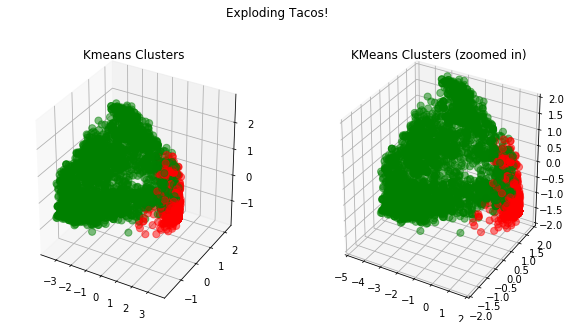

In [34]:
import pylab
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pylab.rcParams['figure.figsize'] = (16.0, 5.0)

X = PCA(n_components=3).fit_transform(domains[cols].to_numpy())
colors = ['green' if x == 1 else 'red' for x in bl_vt_labels]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
fig.suptitle("Exploding Tacos!")
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("Kmeans Clusters")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlim(-5,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("KMeans Clusters (zoomed in)")
plt.show()

<font color='blue'>
 Modified domains.as_matrix(cols) to domains[cols].to_numpy(), domains.as_matrix(bl_cols) to domains[bl_cols].to_numpy(), and domains.as_matrix(vt_cols) to domains[vt_cols].to_numpy() because of warning:
    FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Changed figsize(12,8) to figsize = (12,8) due to error: 
NameError: name 'figsize' is not defined

https://stackoverflow.com/questions/23762238/python-pandas-figsize-not-defined
</font>

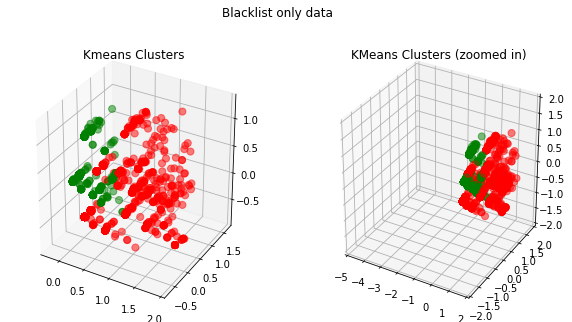

In [35]:
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

X = PCA(n_components=3).fit_transform(domains[bl_cols].to_numpy())
colors = ['green' if x == 1 else 'red' for x in bl_labels]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
fig.suptitle("Blacklist only data")
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("Kmeans Clusters")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlim(-5,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("KMeans Clusters (zoomed in)")
plt.show()

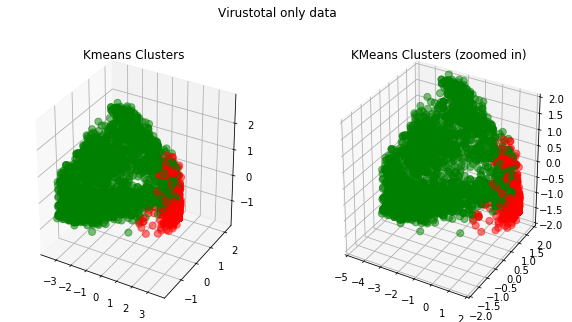

In [36]:
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

X = PCA(n_components=3).fit_transform(domains[vt_cols].to_numpy())
colors = ['green' if x == 1 else 'red' for x in vt_labels]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
fig.suptitle("Virustotal only data")
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("Kmeans Clusters")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlim(-5,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("KMeans Clusters (zoomed in)")
plt.show()

<font color='blue'>
There are some trends in these 3D plots. In my opinion, it is easier to view clusters in a 2D plot. 
</font>

### 2D
Now that you're a wiz at reducing various dimensions to three, it's possible to reduce down to two and graph that. Perhaps some more or different structure will pop out at you.

Once again the blacklist and VirusTotal scenario is done for you, do the same as above and examine the blacklist only and VirusTotal cases in 2D.

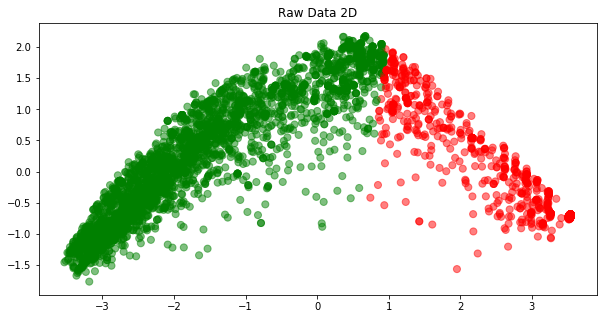

In [37]:
colors = ['green' if x == 1 else 'red' for x in bl_vt_labels]
DD = PCA(n_components=2).fit_transform(domains[cols].to_numpy())
figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Raw Data 2D")
plt.show()

<font color='blue'>
 Modified domains.as_matrix(cols) to domains[cols].to_numpy(), domains.as_matrix(bl_cols) to domains[bl_cols].to_numpy(), and domains.as_matrix(vt_cols) to domains[vt_cols].to_numpy() because of warning:
    FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Changed figsize(12,8) to figsize = (12,8) due to error: 
NameError: name 'figsize' is not defined

https://stackoverflow.com/questions/23762238/python-pandas-figsize-not-defined
</font>

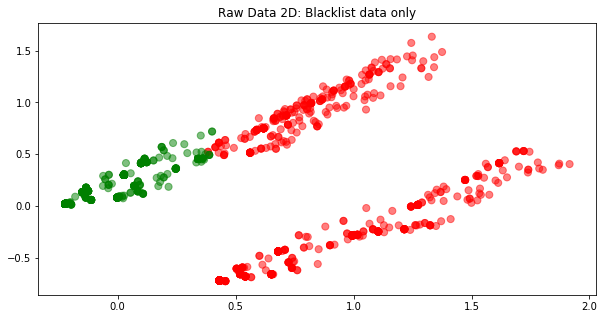

In [38]:
colors = ['green' if x == 1 else 'red' for x in bl_labels]
DD = PCA(n_components=2).fit_transform(domains[bl_cols].to_numpy())
figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Raw Data 2D: Blacklist data only")
plt.show()

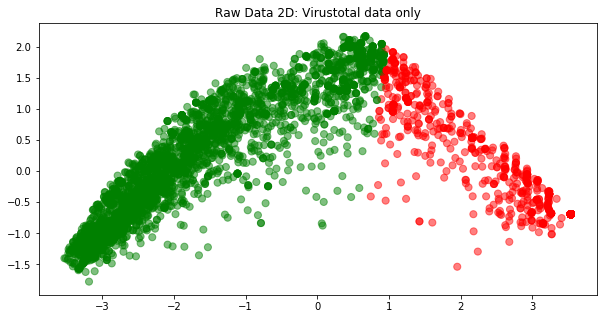

In [39]:
colors = ['green' if x == 1 else 'red' for x in vt_labels]
DD = PCA(n_components=2).fit_transform(domains[vt_cols].to_numpy())
figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Raw Data 2D: Virustotal data only")
plt.show()

<font color='blue'>
These 2D plots show that there is a clear separation between the red (zero's) and green (one's) clusters. 
</font>

### 1D
Our last stop on this journey is 1D. The insights gained by visualizing the data in both three and two dimensions can be pretty helpful. As the beginning of the lab stated our goal is to create some kind of ranking or prioritization of the domains which is just a one-dimensional task. We'll cheat a little bit since looking at a list of numbers isn't that pretty. We'll cheat a bit for the graphing and plot our points along the X-axis with a Y value of 0 for each point.

The case of all the features has been provided for you, repeat the process for blacklist only and AV only.

5144


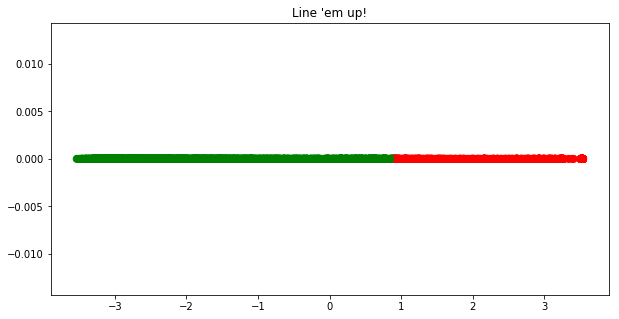

In [40]:
import numpy as np

colors = ['green' if x == 1 else 'red' for x in bl_vt_labels]
D = PCA(n_components=1).fit_transform(domains[cols].to_numpy())
print(len(D))
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, color=colors)
ax.set_title("Line 'em up!")
plt.show()

<font color='blue'>
 Modified domains.as_matrix(cols) to domains[cols].to_numpy(), domains.as_matrix(bl_cols) to domains[bl_cols].to_numpy(), and domains.as_matrix(vt_cols) to domains[vt_cols].to_numpy() because of warning:
    FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Changed figsize(12,8) to figsize = (12,8) due to error: 
NameError: name 'figsize' is not defined

https://stackoverflow.com/questions/23762238/python-pandas-figsize-not-defined
</font>

5144


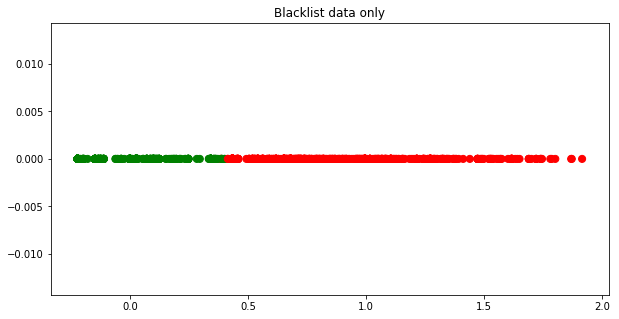

In [41]:
colors = ['green' if x == 1 else 'red' for x in bl_labels]
D = PCA(n_components=1).fit_transform(domains[bl_cols].to_numpy())
print(len(D))
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, color=colors)
ax.set_title("Blacklist data only")
plt.show()

5144


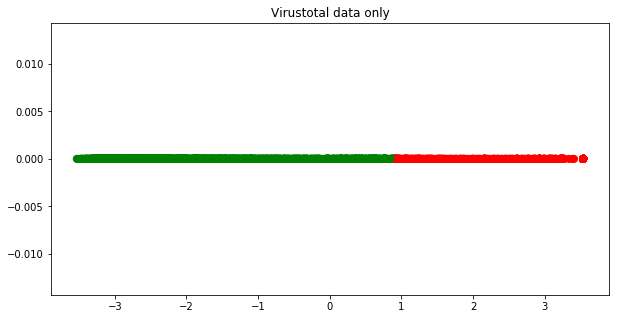

In [42]:
colors = ['green' if x == 1 else 'red' for x in vt_labels]
D = PCA(n_components=1).fit_transform(domains[vt_cols].to_numpy())
print(len(D))
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, color=colors)
ax.set_title("Virustotal data only")
plt.show()

## Scaled Data
One of the final things we can do with this information is scale the feature returned by PCA in this instance. This shifts the data so all values are between zero and one. Giving a really nice scale.

The case of both AV and blacklist is once again provided, perform the same operation/graph for AV only and blacklist only.

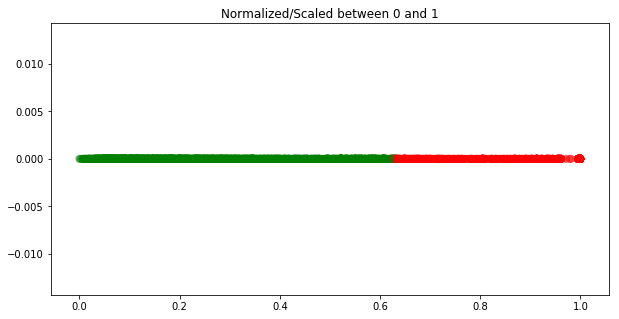

In [43]:
D = PCA(n_components=1).fit_transform(domains[cols].to_numpy())
D = [(x - D.min())/(D.max() - D.min()) for x in D]
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Normalized/Scaled between 0 and 1")
plt.show()

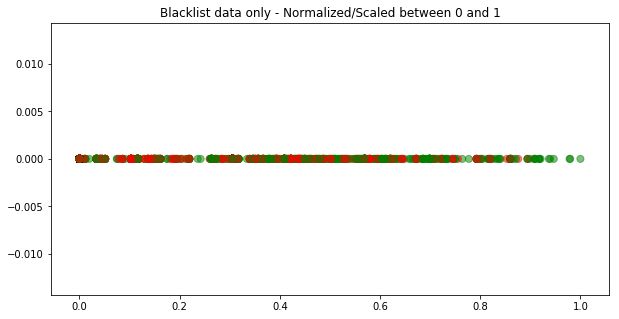

In [44]:
D = PCA(n_components=1).fit_transform(domains[bl_cols].to_numpy())
D = [(x - D.min())/(D.max() - D.min()) for x in D]
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Blacklist data only - Normalized/Scaled between 0 and 1")
plt.show()

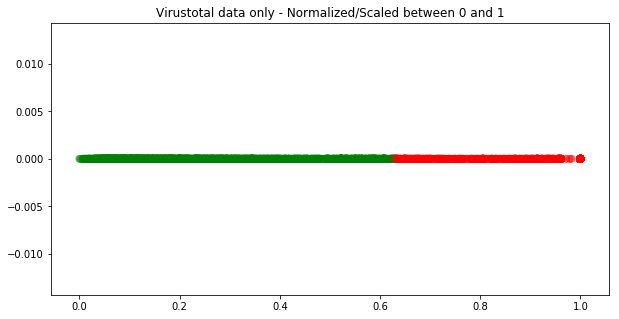

In [45]:
D = PCA(n_components=1).fit_transform(domains[vt_cols].to_numpy())
D = [(x - D.min())/(D.max() - D.min()) for x in D]
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize = (12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Virustotal data only - Normalized/Scaled between 0 and 1")
plt.show()

<font color='blue'>
There didn't seem to be a distinction between the clusters in the Blacklist data only 1D plot.

Both of the other 1D plots showed that there is a clear separation between the red (zero's) and green (one's) clusters.
</font>

## Putting It All Together

After doing all that work to attempt to order and group data, it's time to make use of the results. Remember, that the labels *0* and *1* are arbitrary so it will take assigning the values back and you interpreting the data to understand what's going on.

Here's one of the ways to assign and look at domains. This is just for the AV and blacklist results, so you should do the same with the other labels/values.

When does this seem to work, when does it seem to fail? How valuable do you think this kind of technique is?

In [50]:
D = PCA(n_components=1).fit_transform(domains[cols].to_numpy())
D = [(x - D.min())/(D.max() - D.min()) for x in D]
domains.assign(bl_vt_scaled=D)
domains[['host','bl_vt_scaled']].head()

,host,bl_vt_scaled
0,02b123c.netsolhost.com,0.999260
1,0hb.ru,0.291844
2,0lilioo0l0o00lilil.info,0.644772
3,0n1u4og97yt85sy8faitxwt.addirectory.org,0.359059
4,0td4nbde7.ttl60.com,0.067429


<font color='blue'>
Modified domains.as_matrix(cols) to domains[cols].to_numpy() because of warning:
FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.

Changed domains['bl_vt_scaled'] = D  to domains.assign(bl_vt_scaled=D) because of warning:
SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

https://cmdlinetips.com/2019/01/3-ways-to-add-new-columns-to-pandas-dataframe/
</font>

In [51]:
domains[domains['host'] == '0td4nbde7.ttl60.com'][['detections','detection_count','av_detections','av_count']]

,detections,detection_count,av_detections,av_count
4,"[SpamhausDBL, BitDefender]",2,Bkav,46


In [52]:
domains[domains['bl_vt_scaled'] == 1]['host'].unique()

array(['download.yspbrsz.net'], dtype=object)

In [53]:
domains[domains['host'] == 'turningsbyterry.com'][['detections','detection_count','av_detections','av_count']]

,detections,detection_count,av_detections,av_count


In [54]:
domains[domains['bl_vt_scaled'] == 0]['host'].unique()

array(['ww.turningsbyterry.com'], dtype=object)

In [55]:
domains[domains['host'] == 'download.yspbrsz.net'][['detections','detection_count','av_detections','av_count']]

,detections,detection_count,av_detections,av_count
1337,"[SCUMWARE, Avira, MalwarePatrol]",3,[],0


<font color='blue'>
I have not used MinMax scaling so I can't tell if it is a useful technique. So, I choose to not complete the rest of the exercises, but those solutions are available in the solutions manual.
    
https://rasbt.github.io/mlxtend/user_guide/preprocessing/minmax_scaling/
</font>

# Fin

<font color='blue'>
Final Comment: This lab gave some hands-on experience with Kmeans and Principle Component Analysis (PCA). Both of these are common techniques used in machine learning. The graphs are great tools to visualize the clusters. I would recommend using 2D plots are these are easier to understand. 
    
Despite all of the debugging, I have learned more about list comprehensions and manipulating dataframes. There are still fundamental principles missing from this lab that the reader should take care to understand: how to choose the clusters for Kmeans, how does Kmeans and PCA works, why should data be scaled, what are the advantages of using Kmeans versus other clustering methods, etc. 
</font>